# 1. Подготовка

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import re
import numpy  as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import statistics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
!pip install catboost
from catboost import CatBoostClassifier
from catboost import Pool, cv

In [3]:
comments = pd.read_csv('/content/drive/My Drive/Colab Notebooks/toxic_comments.csv')

In [4]:
comments.info()
#нет пропусков , с форматом все в порядке

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
comments['text'].duplicated().sum()
#полных дубликатов - нет. а вдруг)

0

In [6]:
comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


0    143346
1     16225
Name: toxic, dtype: int64

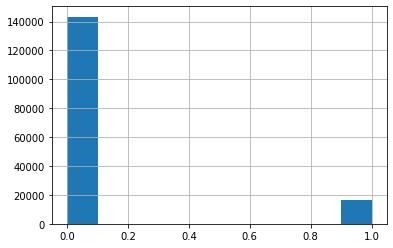

In [7]:
comments['toxic'].hist()
comments['toxic'].value_counts()
#есть явный дисбаланс
#в дальнейшем с ним нужно бороться
#забегая вперед - апсемплинг, даунсемплинг положительных результатов не показывали
#настраивал веса классов в моделях вручную, автоматический баланс - показывал результаты хуже.

In [8]:
print('Процентное соотношение классов:',comments['toxic'].mean())

Процентное соотношение классов: 0.10167887648758234


In [9]:
%%time
#Wall time: 1.9 s
#очиcтим текст от ненужных символов
def clear_text(text):
    subs = re.sub(r'[^a-zA-Z ^0-9]', ' ', text)
    clear_txt =  ' '.join(subs.split())
    return clear_txt

comments['clear'] = comments['text'].apply(
  lambda x: clear_text(x))

CPU times: user 2.07 s, sys: 26 ms, total: 2.1 s
Wall time: 2.11 s


Займемся преобразованием текста , будем использовать NLTK

In [10]:
%%time
#Wall time: 48.6 s
#разобъем на слова
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords as nltk_stopwords

def token(text):
    words = nltk.word_tokenize(text)
    return words

comments['token'] = comments['clear'].apply(
  lambda x: token(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
CPU times: user 50.5 s, sys: 376 ms, total: 50.9 s
Wall time: 51 s


In [11]:
%%time
#Wall time: 35.1 s
#лемматизируем
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemma(text):
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in text])
    return  lemmatized_output     

comments['lemma'] = comments['token'].apply(
  lambda x: lemma(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
CPU times: user 35.8 s, sys: 334 ms, total: 36.2 s
Wall time: 36.2 s


In [12]:
%%time
#Wall time: 10.8 s
#уберм стоп слова
#не указывал список стоп-слов при создании TfidfVectorizer, метрика падала
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

def clear_stopwords(text): 
        
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    text_clear = pattern.sub('', text)
    return text_clear

comments['final_text'] = comments['lemma'].apply(
      lambda x: clear_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
CPU times: user 10.5 s, sys: 31 ms, total: 10.5 s
Wall time: 10.5 s


In [13]:
comments.head()
#получили финальную таблицу с преобработанным текстом.

,text,toxic,clear,token,lemma,final_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,"[Explanation, Why, the, edits, made, under, my...",Explanation Why the edits made under my userna...,Explanation Why edits made username Hardcore M...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,"[D, aww, He, matches, this, background, colour...",D aww He match this background colour I m seem...,D aww He match background colour I seemingly s...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...,"[Hey, man, I, m, really, not, trying, to, edit...",Hey man I m really not trying to edit war It s...,Hey man I really trying edit war It guy consta...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...,"[More, I, can, t, make, any, real, suggestions...",More I can t make any real suggestion on impro...,More I make real suggestion improvement I wond...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,"[You, sir, are, my, hero, Any, chance, you, re...",You sir are my hero Any chance you remember wh...,You sir hero Any chance remember page


# 2. Обучение

In [14]:
#эти данные мы будем применять для векторизации без N-грамм
target = comments['toxic']
features = comments['final_text']
features_train, features_test, target_train, target_test = train_test_split(
features, target,  test_size=0.20, random_state=8888)
#Для задач NLP важен объём именно обучающей выборки.

In [15]:
print('Процентное соотношение классов в учебной выборке:',target_train.mean())
#почти не изменилось

Процентное соотношение классов в учебной выборке: 0.10205552422134487


In [16]:
print('Процентное соотношение классов в тестовой выборке:',target_test.mean())
#почти не изменилось

Процентное соотношение классов в тестовой выборке: 0.1001723327588908


Что чтобы применить N-граммы, необходимо оставить все слова на месте и производить векторизацию, не убирая стоп слова.
Эти данные оставил для векторизации с применением N-грамм

target = comments['toxic']
features = comments['clear']
features_train, features_test, target_train, target_test = train_test_split(
features, target,  test_size=0.30, random_state=8888)

при применении N-грамм результаты на LogisticRegression после cv были чуть хуже, чем без пременения таковых
а именно 0.7606624057281104  по целевой метрике. Поскольку других кретериев оценки в данном проекте мы не 
рассматривали, я решил отказаться от применения N-грамм

Осуществим векторизацию с помощью tf_idf

In [17]:
#векторизация
count_tf_idf = TfidfVectorizer()  #ngram_range=(1, 2) #stop_words=stopwords
features_train = count_tf_idf.fit_transform(features_train)
features_test = count_tf_idf.transform(features_test)

In [ ]:
#1h 22m 28s
model_CatC = CatBoostClassifier(random_state=888,
                           verbose=100, class_weights=[1, 4.5], iterations = 1000)


model_CatC.fit(features_train, target_train)

Обучим модели:

In [18]:
%%time
#Wall time: 6.67 s
model_LogReg = LogisticRegression(random_state=888, class_weight={0:1,1:4.3})

model_LogReg.fit(features_train, target_train)


CPU times: user 7.78 s, sys: 5.25 s, total: 13 s
Wall time: 6.67 s


In [19]:
def cros_val(model,features_t,target_t):

    score_f1 = statistics.mean(cross_val_score(model, features_t,\
                                                        target_t, cv=5, scoring='f1'))
    print('Метрика F1 для модели', model,':',score_f1)

In [20]:
%%time
#Wall time: 28.5 s
cros_val(model_LogReg, features_train, target_train)

Метрика F1 для модели LogisticRegression(C=1.0, class_weight={0: 1, 1: 4.3}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) : 0.7823115292888225
CPU times: user 34.2 s, sys: 22.9 s, total: 57.1 s
Wall time: 29.1 s


In [21]:
#проверка на константной модели
predicted_model_const = pd.Series(target_train.min(), index=target_train.index)
print("Метрика F1 для константной модели :", f1_score(target_train, predicted_model_const))
print("Метрика accuracy_score для константной модели :",accuracy_score(target_train, predicted_model_const))
# Показатель F1 меры равен 0 по причине вывода константной модели лишь отрицательных ответов.
#accuracy_score равен 0,89, здорово)! Но вспомним про дисбаланс классов.

Метрика F1 для константной модели : 0.0
Метрика accuracy_score для константной модели : 0.8979444757786551


По итогу - LogisticRegression дает приемлемый результат при ручной подборке весов, то же касается и Catboost.
Проводить grid_search - в CatBoost с cv не стал(Сделал grid_search когда обрабатывал данных с помощью bert).

Осуществим обработку текста с помощью BERT.

BERT обучался на последовательностях длины не больше 512 токенов, но, как я понимаю, этого с избытком хватает для нашей задачи. И, посмотрев распределение длинн токенов, можно прийти к выводу, что большинство их входит в 400. Именно ей я и ограничился. Все это ускорило получение эмбиндингов.
Результаты модели CatBoostClassifier по метрике f1 на тестовой выборке: 0.6934299954689623
Результаты модели LogisticRegression по метрике f1 на тестовой выборке: 0.705975256646486
Выдающимися их не назовешь...
Возможно стоило ещё поработать на моделями.


In [22]:
import tensorflow as tf
# Get the GPU device name.
device_name = tf.test.gpu_device_name()
# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [23]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [24]:
comments = pd.read_csv('/content/drive/My Drive/Colab Notebooks/toxic_comments.csv')

In [25]:
comments.drop([159570, 159569, 159568], inplace=True)
#подгоним размер под батчи
len(comments)

159568

In [26]:
!pip install transformers
import transformers as ppb

     |████████████████████████████████| 1.3MB 4.7MB/s 
     |████████████████████████████████| 890kB 15.6MB/s 
     |████████████████████████████████| 1.1MB 30.3MB/s 
     |████████████████████████████████| 2.9MB 48.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=fb156542a4cc1ad0d9b790b2a212dd663f0e7eb31242698db451349e84e2b5f2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [27]:
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Загрузка предобученной модели/токенизатора 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [28]:
if torch.cuda.is_available():
  model.cuda()
  model.to(device)

In [29]:
%%time
#Wall time: 3min 8s
tokenized = comments['text'].apply((lambda x: tokenizer.encode(x, max_length=400, truncation=True, add_special_tokens=True)))

CPU times: user 3min 47s, sys: 407 ms, total: 3min 48s
Wall time: 3min 48s


In [30]:
#максимальная длинна нам уже известна, мы установили её на 400
max_len = 400

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
from tqdm import notebook
batch_size = 16
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        
#10638/10638 [1:18:16<00:00, 2.27it/s]

In [ ]:
target_bert = comments['toxic']
features_bert = np.concatenate(embeddings)
features_train_bert, features_test_bert, target_train_bert, target_test_bert = train_test_split(
    features_bert, target_bert, test_size=0.30, random_state=12345)

In [ ]:
model_LogReg_bert = LogisticRegression(random_state=888, class_weight={0 : 1, 1 : 1.4} )

model_LogReg_bert.fit(features_train_bert, target_train_bert)

In [ ]:
def cros_val(model,features_t,target_t):

    score_f1 = statistics.mean(cross_val_score(model, features_t,\
                                                        target_t, cv=5, scoring='f1'))
    print('Метрика F1 для модели', model,':',score_f1)

In [ ]:
cros_val(model_LogReg_bert, features_train_bert, target_train_bert)
#Метрика F1 для модели LogisticRegression(C=1.0, class_weight={0: 1, 1: 4.3}, dual=False,
                   #fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   #max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   #random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   #warm_start=False) : 0.7035912049841136

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier
from catboost import Pool, cv
model_Cat_bert = CatBoostClassifier()


cv_dataset = Pool(data=features_train_bert,
                  label=target_train_bert)

grid = {'learning_rate': [0.03 ,0.3, 0.6],
        'depth': [3,4,6],
        'class_weights':[[1, 4.5],[1, 1.5]]}

grid_search_result = model_Cat_bert.grid_search(grid, 
                                       X=cv_dataset,
                                          verbose=1)

In [ ]:
grid_search_result
# 'params': {'class_weights': [1.0, 4.5], 'depth': 6, 'learning_rate': 0.03}}

In [ ]:
predict_log_bert = model_LogReg_bert.predict(features_test_bert)
predict_cat_bert = model_Cat_bert.predict(features_test_bert)
f1_log = f1_score(target_test_bert, predict_log_bert)
f1_cat = f1_score(target_test_bert, predict_cat_bert)
print("Результаты модели CatBoostClassifier по метрике f1:", f1_cat)
print("Результаты модели LogisticRegression по метрике f1:", f1_log)

#Результаты модели CatBoostClassifier по метрике f1: 0.6934299954689623
#Результаты модели LogisticRegression по метрике f1: 0.705975256646486

# Проверим модели на тестовой выборке

In [ ]:
#посмотрим распределение на тестовой выборке
target_test.mean()

In [ ]:
predict_log = model_LogReg.predict(features_test)
#predict_cat = model_CatC.predict(features_test)

In [ ]:
def metrics(target, answer):
    print("F1:", f1_score(target, answer))
    print('====================================================')
    from sklearn import metrics
    print(metrics.classification_report(target, answer))
    tn, fn, fp, tp = confusion_matrix(target, answer).ravel()
    print('True Negdtive:', tn)
    print('False Negative:', fn)
    print('True Positive:', tp)
    print('False Positive:', fp)

In [ ]:
metrics(target_test, predict_log)
#F1: 0.7693247784906813

In [ ]:
metrics(target_test, predict_cat)

In [ ]:
#можно было побаловаться с порогами, но отложил это.
'''df_new = pd.DataFrame({'0':model_LogReg.predict_proba(features_test)[:,0], '1':model_LogReg.predict_proba(features_test)[:,1], 
                      'tru': target_test, 'pred': predict_log})

df_new['pred'] = df_new['1']  > 0.33
df_new['pred'] = (df_new['pred'])*1
tn, fn, fp, tp = confusion_matrix(target_test, df_new['pred']).ravel()
print(tn, fn, fp, tp)'''

# 3. Выводы

Нашей задачей было разработать модель для определения токсичных комментариев и дальнейшей отправки их на модерацию.
Я провёл два варианта обработки текста :
С помощью инструментов nltk и дальнейшей векторизации через TfidfVectorizer.
С помощью инструментов bert
В дальнейшем в обоих вариантах подготовленные данные загружались в две модели - LogisticRegression и CatBoostClassifier.
Результат на целевой метрике сцепок tf_idf / LogisticRegression и tf_idf / CatBoostClassifier почти одинаковы, LogisticRegression естественно шустрее и в процессе  обучения.
Результаты с применением bert были на порядок хуже(явно из за моего невежества)
Если рассматривать полезность нашей роботы, то стоило бы смотреть на такие показатели, как полнота и точность. И обговаривать с заказчиком , что для него важнее: пропустить токсичный комментарий или загрузить модератора лишней работой.
